<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 12 19:04:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 1000
PATIENCE = 25
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 5
OUTPUT_AB = 60
OUTPUT_XY = 2
OUTPUT_D = 10

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            #nn.Conv2d(12, 12, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 12
            
            nn.Conv2d(12, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 16
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 32

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.Conv2d(64, 64, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 128
            
        )
        self.fcc_ab = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_AB)
        )
        self.fcc_xy = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_XY)   
        )
        self.fcc_d = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_D)
        )
    def forward(self, x):
        output = self.cnn(x)
        feature_map = output.view(output.size(0), -1)
        ab = self.fcc_ab(feature_map)
        a = ab[:, :30]
        b = ab[:, 30:]
        xy = self.fcc_xy(feature_map)
        d = self.fcc_d(feature_map)
        return a, b, xy, d

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'singlesource_class'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = 'checkpoint.pt'
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [10]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

 20%|██        | 1/5 [00:17<01:08, 17.06s/it]

250


 40%|████      | 2/5 [00:34<00:51, 17.03s/it]

250


 60%|██████    | 3/5 [00:51<00:34, 17.02s/it]

250


 80%|████████  | 4/5 [01:08<00:17, 17.01s/it]

250


  0%|          | 0/1 [00:00<?, ?it/s]

250


  0%|          | 0/1 [00:00<?, ?it/s]

250


100%|██████████| 1/1 [01:13<00:00, 73.61s/it]

1000
1250
250
1000


In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [12]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    
    #print(x)
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    #x = x.astype(int)
    print(x)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==10:
      break

[[[[ -1.9500284   -1.8537781   -1.7647557  ... -12.381899
    -12.420108   -12.433106  ]
   [ -1.9500284   -2.0175881   -1.9992316  ... -13.132494
    -13.209364   -13.25458   ]
   [ -1.9500284   -2.1666944   -2.1576655  ... -13.379196
    -13.517504   -13.622468  ]
   ...
   [ -1.9500284   -1.5190232   -1.2682472  ... -11.260021
    -11.247219   -11.209218  ]
   [ -1.9500284   -1.6846428   -1.5050472  ... -11.917697
    -11.933225   -11.922149  ]
   [ -1.9500284   -1.8537781   -1.7647557  ... -12.381899
    -12.420108   -12.433106  ]]]


 [[[  8.837031     9.539849     9.649202   ... -12.945779
    -13.072046   -13.121345  ]
   [  8.837031     9.675632     9.970612   ... -12.243461
    -12.3637905  -12.430515  ]
   [  8.837031     9.826474    10.331989   ... -11.130841
    -11.195064   -11.253908  ]
   ...
   [  8.837031     9.342796     9.3279295  ... -11.485901
    -11.442524   -11.391027  ]
   [  8.837031     9.42692      9.421553   ... -12.381318
    -12.428062   -12.418179  ]
   

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
def get_loss(a, b, xy, d, label_a, label_b, label_xy, label_d, weight):
  # a,b : 1 x 30
  # xy : 1 x 2
  # d : 1 x 10
  a = a.to(device)
  b = b.to(device)
  xy = xy.to(device)
  d = d.to(device)

  weight = weight.to(device)


  label_a = label_a.view(len(label_a))
  label_b = label_b.view(len(label_b))
  label_d = label_d.view(len(label_d))
  label_a = label_a.type(torch.cuda.LongTensor)
  label_b = label_b.type(torch.cuda.LongTensor)
  label_d = label_d.type(torch.cuda.LongTensor)

  x = torch.ones(len(label_a))
  x = x.to(device)
  x = x.type(torch.cuda.LongTensor)

  label_a = label_a - x
  label_b = label_b - x

  y = torch.ones(len(label_d))
  y = y.to(device)
  y = y.type(torch.cuda.LongTensor)
  
  label_d = label_d - y

  crit1 = nn.CrossEntropyLoss()
  crit2 = nn.CrossEntropyLoss()
  crit3 = nn.MSELoss()
  crit4 = nn.CrossEntropyLoss()

  loss1 = crit1(a, label_a)
  loss2 = crit2(b, label_b)
  loss3 = crit3(xy, label_xy)
  loss4 = crit4(d, label_d)
  return loss1 * weight[0]  + loss2 * weight[1] + loss3 * weight[2] + loss4 * weight[3]



In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([0.8, 0.8, 1.0, 1.2])
    
    #train_errors = []
    #val_errors = []

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    la = y[:, 0]
                    lb = y[:, 1]
                    lxy = y[:, 2:4]
                    ld = y[:, 4]
                    a, b, xy, d = net(x)


                    la = la.view(-1, 1)
                    lb = lb.view(-1, 1)
                    ld = ld.view(-1, 1)
                    loss = get_loss(a, b, xy, d, la, lb, lxy, ld, weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                    #error = (pred - y) / y
                    #error = error.mean(0)
                    #train_errors.append(error.to("cpu"))

                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    val_x = val_x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    la = val_y[:, 0]
                    lb = val_y[:, 1]
                    lxy = val_y[:, 2:4]
                    ld = val_y[:, 4]
                    a, b, xy, d = net(val_x)
                    loss = get_loss(a, b, xy, d, la, lb, lxy, ld, weight)
                    val_losses.append(loss.item())

                    #val_error = (val_pred - val_y) / val_y
                    #val_error = val_error.mean(0)
                    #val_errors.append(val_error.to("cpu"))

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                #train_error = np.average(train_errors)
                #val_error= np.average(val_errors)

                train_losses = []
                val_losses = []
                #train_errors = []
                #val_errors = []

                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                #print("error : ", train_error, "val error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [0]:
net = Net()
#print(net)


In [44]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)


  0%|          | 1/1000 [00:00<09:47,  1.70it/s]


loss :  113.30728092193604 val loss :  121.98255825042725 

Validation loss decreased (inf --> 121.982558).  Saving model ...



  0%|          | 2/1000 [00:01<09:59,  1.66it/s]


loss :  86.81657056808471 val loss :  79.85695934295654 

Validation loss decreased (121.982558 --> 79.856959).  Saving model ...



  0%|          | 3/1000 [00:01<09:56,  1.67it/s]


loss :  62.00322866439819 val loss :  76.95138359069824 

Validation loss decreased (79.856959 --> 76.951384).  Saving model ...



  0%|          | 4/1000 [00:02<10:01,  1.66it/s]


loss :  57.48671712875366 val loss :  70.96524667739868 

Validation loss decreased (76.951384 --> 70.965247).  Saving model ...



  0%|          | 5/1000 [00:03<10:06,  1.64it/s]


loss :  52.66697330474854 val loss :  70.55097484588623 

Validation loss decreased (70.965247 --> 70.550975).  Saving model ...



  1%|          | 6/1000 [00:03<10:10,  1.63it/s]


loss :  48.667880582809445 val loss :  59.14473867416382 

Validation loss decreased (70.550975 --> 59.144739).  Saving model ...



  1%|          | 7/1000 [00:04<10:18,  1.61it/s]


loss :  45.254612636566165 val loss :  59.91887855529785 

EarlyStopping counter: 1 out of 25



  1%|          | 8/1000 [00:04<10:09,  1.63it/s]


loss :  43.65495743751526 val loss :  56.16596508026123 

Validation loss decreased (59.144739 --> 56.165965).  Saving model ...



  1%|          | 9/1000 [00:05<10:09,  1.62it/s]


loss :  42.554102420806885 val loss :  58.077680587768555 

EarlyStopping counter: 1 out of 25



  1%|          | 10/1000 [00:06<10:11,  1.62it/s]


loss :  41.17757592201233 val loss :  55.21185255050659 

Validation loss decreased (56.165965 --> 55.211853).  Saving model ...



  1%|          | 11/1000 [00:06<10:06,  1.63it/s]


loss :  40.38786406517029 val loss :  56.50232267379761 

EarlyStopping counter: 1 out of 25



  1%|          | 12/1000 [00:07<10:11,  1.62it/s]


loss :  38.17783856391907 val loss :  57.46388387680054 

EarlyStopping counter: 2 out of 25



  1%|▏         | 13/1000 [00:07<10:07,  1.63it/s]


loss :  38.57634010314941 val loss :  55.05632257461548 

Validation loss decreased (55.211853 --> 55.056323).  Saving model ...



  1%|▏         | 14/1000 [00:08<10:14,  1.61it/s]


loss :  37.71285791397095 val loss :  50.71997570991516 

Validation loss decreased (55.056323 --> 50.719976).  Saving model ...



  2%|▏         | 15/1000 [00:09<10:18,  1.59it/s]


loss :  33.987372922897336 val loss :  50.49574565887451 

Validation loss decreased (50.719976 --> 50.495746).  Saving model ...



  2%|▏         | 16/1000 [00:09<10:12,  1.61it/s]


loss :  32.37963213920593 val loss :  49.768494606018066 

Validation loss decreased (50.495746 --> 49.768495).  Saving model ...



  2%|▏         | 17/1000 [00:10<10:18,  1.59it/s]


loss :  31.751012325286865 val loss :  47.58631086349487 

Validation loss decreased (49.768495 --> 47.586311).  Saving model ...



  2%|▏         | 18/1000 [00:11<10:21,  1.58it/s]


loss :  29.762099981307983 val loss :  44.558441162109375 

Validation loss decreased (47.586311 --> 44.558441).  Saving model ...



  2%|▏         | 19/1000 [00:11<10:23,  1.57it/s]


loss :  29.326248836517333 val loss :  46.40949773788452 

EarlyStopping counter: 1 out of 25



  2%|▏         | 20/1000 [00:12<10:24,  1.57it/s]


loss :  28.328969597816467 val loss :  49.04365348815918 

EarlyStopping counter: 2 out of 25



  2%|▏         | 21/1000 [00:13<10:16,  1.59it/s]


loss :  28.116498231887817 val loss :  46.337897539138794 

EarlyStopping counter: 3 out of 25



  2%|▏         | 22/1000 [00:13<10:22,  1.57it/s]


loss :  25.870002651214598 val loss :  41.151252031326294 

Validation loss decreased (44.558441 --> 41.151252).  Saving model ...



  2%|▏         | 23/1000 [00:14<10:15,  1.59it/s]


loss :  25.20333299636841 val loss :  44.66275119781494 

EarlyStopping counter: 1 out of 25



  2%|▏         | 24/1000 [00:14<10:11,  1.60it/s]


loss :  24.733497858047485 val loss :  44.743064880371094 

EarlyStopping counter: 2 out of 25



  2%|▎         | 25/1000 [00:15<10:05,  1.61it/s]


loss :  24.916026544570922 val loss :  46.286935329437256 

EarlyStopping counter: 3 out of 25



  3%|▎         | 26/1000 [00:16<10:08,  1.60it/s]


loss :  25.055509090423584 val loss :  43.88857173919678 

EarlyStopping counter: 4 out of 25



  3%|▎         | 27/1000 [00:16<09:55,  1.63it/s]


loss :  23.059745526313783 val loss :  44.51815986633301 

EarlyStopping counter: 5 out of 25



  3%|▎         | 28/1000 [00:17<10:12,  1.59it/s]


loss :  22.474490380287172 val loss :  40.81657791137695 

Validation loss decreased (41.151252 --> 40.816578).  Saving model ...



  3%|▎         | 29/1000 [00:18<10:13,  1.58it/s]


loss :  22.762731742858886 val loss :  42.1036114692688 

EarlyStopping counter: 1 out of 25



  3%|▎         | 30/1000 [00:18<10:08,  1.59it/s]


loss :  22.00904722213745 val loss :  44.73638701438904 

EarlyStopping counter: 2 out of 25



  3%|▎         | 31/1000 [00:19<10:23,  1.56it/s]


loss :  21.807056403160097 val loss :  48.8133749961853 

EarlyStopping counter: 3 out of 25



  3%|▎         | 32/1000 [00:20<10:14,  1.58it/s]


loss :  21.465935707092285 val loss :  45.377036571502686 

EarlyStopping counter: 4 out of 25



  3%|▎         | 33/1000 [00:20<10:05,  1.60it/s]


loss :  21.351804733276367 val loss :  41.58850336074829 

EarlyStopping counter: 5 out of 25



  3%|▎         | 34/1000 [00:21<10:00,  1.61it/s]


loss :  20.876342177391052 val loss :  48.36608839035034 

EarlyStopping counter: 6 out of 25



  4%|▎         | 35/1000 [00:21<09:49,  1.64it/s]


loss :  21.34518210887909 val loss :  45.78361511230469 

EarlyStopping counter: 7 out of 25



  4%|▎         | 36/1000 [00:22<09:59,  1.61it/s]


loss :  20.283552479743957 val loss :  47.65819501876831 

EarlyStopping counter: 8 out of 25



  4%|▎         | 37/1000 [00:23<09:51,  1.63it/s]


loss :  20.68678526878357 val loss :  41.503032207489014 

EarlyStopping counter: 9 out of 25



  4%|▍         | 38/1000 [00:23<10:01,  1.60it/s]


loss :  22.189608025550843 val loss :  43.24444079399109 

EarlyStopping counter: 10 out of 25



  4%|▍         | 39/1000 [00:24<10:23,  1.54it/s]


loss :  20.36766321659088 val loss :  40.487948179244995 

Validation loss decreased (40.816578 --> 40.487948).  Saving model ...



  4%|▍         | 40/1000 [00:24<10:06,  1.58it/s]


loss :  19.893324494361877 val loss :  46.07060766220093 

EarlyStopping counter: 1 out of 25



  4%|▍         | 41/1000 [00:25<10:09,  1.57it/s]


loss :  19.54952836036682 val loss :  42.954880237579346 

EarlyStopping counter: 2 out of 25



  4%|▍         | 42/1000 [00:26<10:09,  1.57it/s]


loss :  19.316833639144896 val loss :  39.81336259841919 

Validation loss decreased (40.487948 --> 39.813363).  Saving model ...



  4%|▍         | 43/1000 [00:26<10:00,  1.59it/s]


loss :  19.90804240703583 val loss :  46.92925453186035 

EarlyStopping counter: 1 out of 25



  4%|▍         | 44/1000 [00:27<09:56,  1.60it/s]


loss :  19.353080987930298 val loss :  41.56402325630188 

EarlyStopping counter: 2 out of 25



  4%|▍         | 45/1000 [00:28<09:46,  1.63it/s]


loss :  18.60700979232788 val loss :  43.54715967178345 

EarlyStopping counter: 3 out of 25



  5%|▍         | 46/1000 [00:28<09:54,  1.60it/s]


loss :  18.370502042770386 val loss :  42.8251953125 

EarlyStopping counter: 4 out of 25



  5%|▍         | 47/1000 [00:29<09:41,  1.64it/s]


loss :  18.27922797203064 val loss :  41.55852270126343 

EarlyStopping counter: 5 out of 25



  5%|▍         | 48/1000 [00:29<09:51,  1.61it/s]


loss :  17.17640702724457 val loss :  42.532386302948 

EarlyStopping counter: 6 out of 25



  5%|▍         | 49/1000 [00:30<09:49,  1.61it/s]


loss :  18.19122998714447 val loss :  45.00987935066223 

EarlyStopping counter: 7 out of 25



  5%|▌         | 50/1000 [00:31<09:52,  1.60it/s]


loss :  17.97916796207428 val loss :  44.08167839050293 

EarlyStopping counter: 8 out of 25



  5%|▌         | 51/1000 [00:31<09:54,  1.59it/s]


loss :  17.80823678970337 val loss :  41.86448860168457 

EarlyStopping counter: 9 out of 25



  5%|▌         | 52/1000 [00:32<09:51,  1.60it/s]


loss :  17.072249484062194 val loss :  45.10689353942871 

EarlyStopping counter: 10 out of 25



  5%|▌         | 53/1000 [00:33<09:59,  1.58it/s]


loss :  18.197686886787416 val loss :  49.11300492286682 

EarlyStopping counter: 11 out of 25



  5%|▌         | 54/1000 [00:33<09:50,  1.60it/s]


loss :  17.39088668823242 val loss :  45.466228008270264 

EarlyStopping counter: 12 out of 25



  6%|▌         | 55/1000 [00:34<09:46,  1.61it/s]


loss :  16.98715808391571 val loss :  41.203322887420654 

EarlyStopping counter: 13 out of 25



  6%|▌         | 56/1000 [00:34<09:46,  1.61it/s]


loss :  17.008451080322267 val loss :  43.4284143447876 

EarlyStopping counter: 14 out of 25



  6%|▌         | 57/1000 [00:35<09:40,  1.63it/s]


loss :  17.392352437973024 val loss :  43.37240552902222 

EarlyStopping counter: 15 out of 25



  6%|▌         | 58/1000 [00:36<09:53,  1.59it/s]


loss :  16.81554307937622 val loss :  45.51976203918457 

EarlyStopping counter: 16 out of 25



  6%|▌         | 59/1000 [00:36<09:40,  1.62it/s]


loss :  16.53836898803711 val loss :  41.020315170288086 

EarlyStopping counter: 17 out of 25



  6%|▌         | 60/1000 [00:37<09:47,  1.60it/s]


loss :  16.502299666404724 val loss :  44.239800453186035 

EarlyStopping counter: 18 out of 25



  6%|▌         | 61/1000 [00:38<09:44,  1.61it/s]


loss :  16.631812286376952 val loss :  43.70567965507507 

EarlyStopping counter: 19 out of 25



  6%|▌         | 62/1000 [00:38<09:38,  1.62it/s]


loss :  16.04275529384613 val loss :  43.67838191986084 

EarlyStopping counter: 20 out of 25



  6%|▋         | 63/1000 [00:39<09:44,  1.60it/s]


loss :  17.295038676261903 val loss :  44.36651277542114 

EarlyStopping counter: 21 out of 25



  6%|▋         | 64/1000 [00:39<09:36,  1.62it/s]


loss :  15.792326664924621 val loss :  42.28439402580261 

EarlyStopping counter: 22 out of 25



  6%|▋         | 65/1000 [00:40<09:52,  1.58it/s]


loss :  15.926841044425965 val loss :  42.233736515045166 

EarlyStopping counter: 23 out of 25



  7%|▋         | 66/1000 [00:41<09:45,  1.59it/s]


loss :  16.120715403556822 val loss :  47.9753315448761 

EarlyStopping counter: 24 out of 25



  7%|▋         | 67/1000 [00:41<09:50,  1.58it/s]


loss :  15.643231773376465 val loss :  37.2556688785553 

Validation loss decreased (39.813363 --> 37.255669).  Saving model ...



  7%|▋         | 68/1000 [00:42<09:56,  1.56it/s]


loss :  15.74706461429596 val loss :  39.4466347694397 

EarlyStopping counter: 1 out of 25



  7%|▋         | 69/1000 [00:43<09:48,  1.58it/s]


loss :  15.497300720214843 val loss :  42.51018667221069 

EarlyStopping counter: 2 out of 25



  7%|▋         | 70/1000 [00:43<09:39,  1.60it/s]


loss :  15.36676664352417 val loss :  44.327887535095215 

EarlyStopping counter: 3 out of 25



  7%|▋         | 71/1000 [00:44<09:44,  1.59it/s]


loss :  15.770124363899232 val loss :  40.9292426109314 

EarlyStopping counter: 4 out of 25



  7%|▋         | 72/1000 [00:44<09:42,  1.59it/s]


loss :  15.752417016029359 val loss :  40.55372071266174 

EarlyStopping counter: 5 out of 25



  7%|▋         | 73/1000 [00:45<09:41,  1.59it/s]


loss :  15.483873558044433 val loss :  39.20221257209778 

EarlyStopping counter: 6 out of 25



  7%|▋         | 74/1000 [00:46<09:32,  1.62it/s]


loss :  15.035267996788026 val loss :  43.84497022628784 

EarlyStopping counter: 7 out of 25



  8%|▊         | 75/1000 [00:46<09:34,  1.61it/s]


loss :  14.786662292480468 val loss :  43.468456745147705 

EarlyStopping counter: 8 out of 25



  8%|▊         | 76/1000 [00:47<09:29,  1.62it/s]


loss :  14.803876328468323 val loss :  41.7331280708313 

EarlyStopping counter: 9 out of 25



  8%|▊         | 77/1000 [00:48<09:31,  1.62it/s]


loss :  14.629712533950805 val loss :  45.032283544540405 

EarlyStopping counter: 10 out of 25



  8%|▊         | 78/1000 [00:48<09:41,  1.59it/s]


loss :  14.938372588157653 val loss :  47.12823414802551 

EarlyStopping counter: 11 out of 25



  8%|▊         | 79/1000 [00:49<09:36,  1.60it/s]


loss :  14.88147575855255 val loss :  51.333523750305176 

EarlyStopping counter: 12 out of 25



  8%|▊         | 80/1000 [00:49<09:32,  1.61it/s]


loss :  15.843886709213256 val loss :  41.68459177017212 

EarlyStopping counter: 13 out of 25



  8%|▊         | 81/1000 [00:50<09:35,  1.60it/s]


loss :  15.016675090789795 val loss :  39.56912660598755 

EarlyStopping counter: 14 out of 25



  8%|▊         | 82/1000 [00:51<09:39,  1.59it/s]


loss :  14.587033891677857 val loss :  42.88182973861694 

EarlyStopping counter: 15 out of 25



  8%|▊         | 83/1000 [00:51<09:42,  1.57it/s]


loss :  15.16699857711792 val loss :  44.53848075866699 

EarlyStopping counter: 16 out of 25



  8%|▊         | 84/1000 [00:52<09:27,  1.61it/s]


loss :  14.321128726005554 val loss :  40.220093727111816 

EarlyStopping counter: 17 out of 25



  8%|▊         | 85/1000 [00:53<09:40,  1.58it/s]


loss :  14.354833555221557 val loss :  43.888251543045044 

EarlyStopping counter: 18 out of 25



  9%|▊         | 86/1000 [00:53<09:48,  1.55it/s]


loss :  14.29805040359497 val loss :  40.59744644165039 

EarlyStopping counter: 19 out of 25



  9%|▊         | 87/1000 [00:54<09:48,  1.55it/s]


loss :  14.514200925827026 val loss :  38.05964136123657 

EarlyStopping counter: 20 out of 25



  9%|▉         | 88/1000 [00:55<09:38,  1.58it/s]


loss :  14.162056636810302 val loss :  44.322022676467896 

EarlyStopping counter: 21 out of 25



  9%|▉         | 89/1000 [00:55<09:35,  1.58it/s]


loss :  14.292714309692382 val loss :  41.62497162818909 

EarlyStopping counter: 22 out of 25



  9%|▉         | 90/1000 [00:56<09:43,  1.56it/s]


loss :  13.874453711509705 val loss :  45.56064200401306 

EarlyStopping counter: 23 out of 25



  9%|▉         | 91/1000 [00:56<09:36,  1.58it/s]


loss :  13.9712806224823 val loss :  41.44426703453064 

EarlyStopping counter: 24 out of 25


  9%|▉         | 91/1000 [00:57<09:34,  1.58it/s]


loss :  14.29935793876648 val loss :  47.650596618652344 

EarlyStopping counter: 25 out of 25
Early stopping


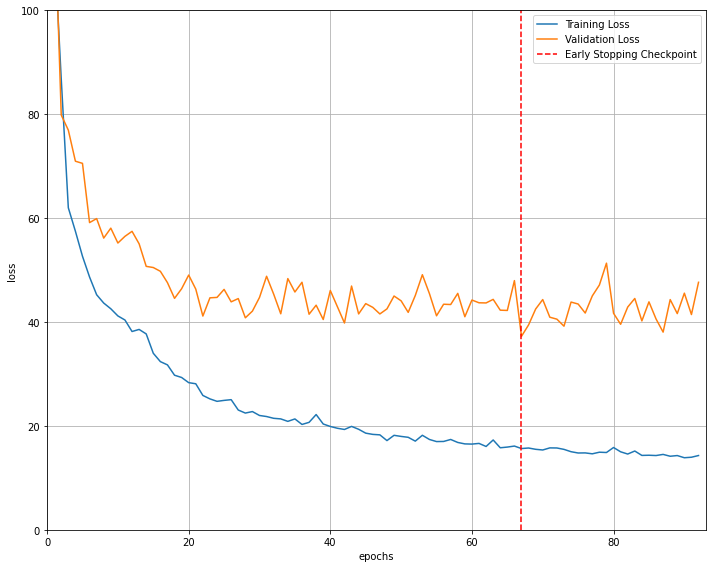

In [46]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            predict = []
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            a, b, xy, d = net(x)
            #print(a)
            #print(b)
            #print(xy)
            #print(d)
            _, aa = a.max(1)
            _, bb = b.max(1)
            _, dd = d.max(1)
            aa = aa.to("cpu")
            bb = bb.to("cpu")
            xy = xy.to("cpu")
            dd = dd.to("cpu")
            x = xy[:,0]
            y = xy[:,1]
            predict.append(aa)
            predict.append(bb)
            predict.append(x)
            predict.append(y)
            predict.append(dd)
            #print(predict)
            predict = np.array(predict)
            predictions.append(predict)
            

    print(predictions)
    print()
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [51]:
testsets = []
for f in tqdm(os.listdir(TEST_PATH_LABEL)):
  path  = os.path.join(TEST_PATH_LABEL, f)
  testset = DataCaller_Excel(path, IMG_SIZE)
  print(testset.__len__())
  testsets.append(testset)

testset = ConcatDataset(testsets)


100%|██████████| 1/1 [01:15<00:00, 75.51s/it]

1000


In [0]:
trained_net = Net()
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.to(device)
trained_net.eval()
test(trained_net)